# **Test Pre-trained CheXNet**

## **Import Libraries**

In [1]:
from google.colab import drive
import os
import shutil
import time
from tqdm import tqdm
import glob
import gc

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import random as rn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from keras.models import Model

## **Unzip Dataset from Google Drive**

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CIDL_Group/DATASET.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO/train/Infiltration/00007034_029.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO/train/Infiltration/00007514_010.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO/train/Infiltration/00027637_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO/train/Infiltration/00014798_013.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO/train/Infiltration/00021572_014.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO/train/Infiltration/00025320_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO/train/Infiltration/00024315_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO/train/Infiltration/00027846_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Grou

## **Set Environmental Parameters**

In [3]:
seed = 42
# The below is necessary for reproducible results of certain Python hash-based operations.
os.environ["PYTHONHASHSEED"]="0"
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(seed)
# The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
tf.random.set_seed(seed)

In [4]:
BASE_PATH = '/content/drive/MyDrive/CIDL_Group'
MODELS_PATH = os.path.join(BASE_PATH, 'PRE-TRAINED_MODELS', 'CheXNet')
LOCAL_MODELS_PATH = os.path.join(BASE_PATH, 'tmp_models')
WEIGHTS = os.path.join(BASE_PATH, '/content/drive/MyDrive/CIDL_Group/PRE-TRAINED_MODELS/CheXNet_weights.h5')

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

AUTOTUNE = tf.data.AUTOTUNE
INTERPOLATION = "bilinear"


LOSS_FUNC = 'sparse_categorical_crossentropy'

METRICS = ['accuracy']

In [ ]:
DATASET_PATH = '/content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')
CLASSES = os.listdir(TRAIN_PATH)

## **Check Class Distribution**

In [5]:
def get_class_distribution(dataset, to_print=False):
  
  len([name for name in os.listdir(dataset) if os.path.isfile(os.path.join(dataset, name))])

  distribution = []
  total = 0
  for dir in tqdm(os.listdir(dataset)):
    sub_dir = dataset + "/" + dir + "/*"
    number = len(glob.glob(sub_dir))
    distribution.append(number)
    total += number
    
  if print:
    for i in range(len(CLASSES)):
      print(f'Number of {CLASSES[i]}: {distribution[i]}, proportion: {distribution[i]/(total)}')
  
  return distribution, total


def plot_class_distribution(dataset, name):
  distribution, _ = get_class_distribution(dataset, to_print=True)

  plt.figure(figsize=(10, 6), dpi=80)
  plt.bar(CLASSES, height=distribution)
  plt.title(f'Barplot of class distribution of {name} dataset')
  plt.show()

100%|██████████| 4/4 [00:00<00:00, 25.30it/s]


Number of No Finding: 2430, proportion: 0.3376876042245692
Number of Atelectasis: 1211, proportion: 0.16828793774319067
Number of Effusion: 1125, proportion: 0.15633685380767093
Number of Infiltration: 2430, proportion: 0.3376876042245692


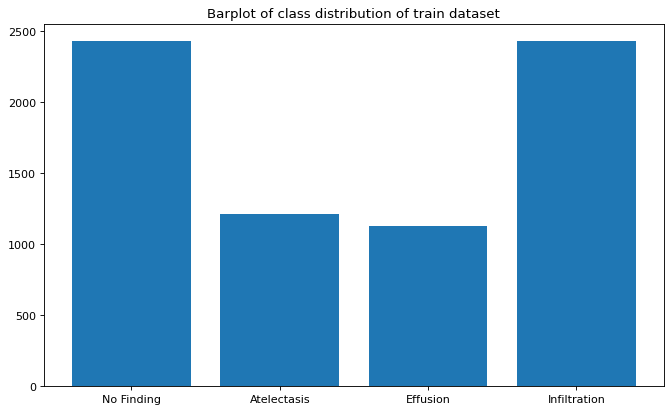

100%|██████████| 4/4 [00:00<00:00, 308.48it/s]


Number of No Finding: 270, proportion: 0.3375
Number of Atelectasis: 135, proportion: 0.16875
Number of Effusion: 125, proportion: 0.15625
Number of Infiltration: 270, proportion: 0.3375


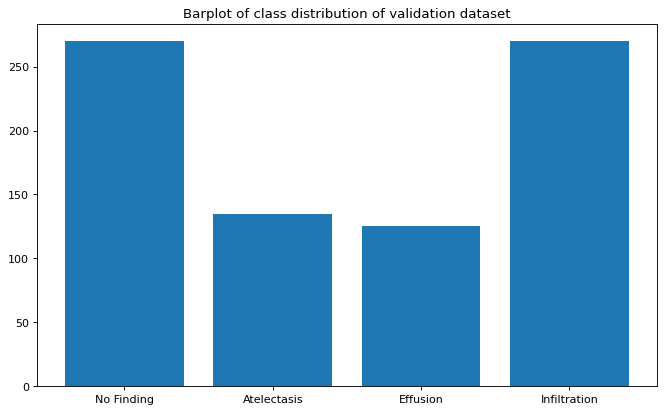

100%|██████████| 4/4 [00:00<00:00, 299.66it/s]


Number of No Finding: 300, proportion: 0.3374578177727784
Number of Atelectasis: 150, proportion: 0.1687289088863892
Number of Effusion: 139, proportion: 0.156355455568054
Number of Infiltration: 300, proportion: 0.3374578177727784


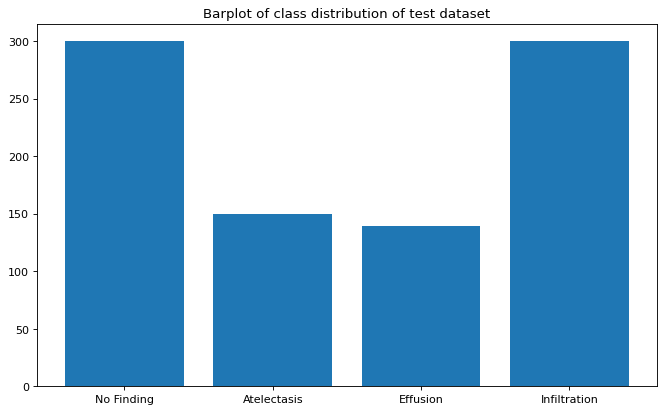

In [ ]:
plot_class_distribution(TRAIN_PATH, 'train')
plot_class_distribution(VAL_PATH, 'validation')
plot_class_distribution(TEST_PATH, 'test')

## **Utility Functions**

In [6]:
def extract_labels(ds):
  ds_labels = []
  for images, labels in ds.unbatch():
    ds_labels.append(labels.numpy())
  return np.array(ds_labels)


def show_training_and_validation_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def load_training_set (image_size, batch_size, shuffle=True):
  train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE
  )
  train_ds = train_ds.cache()
  if shuffle:
    train_ds = train_ds.shuffle(BATCH_SIZE * 100)
  train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
  return train_ds


def load_validation_set (image_size, batch_size):
  val_ds = image_dataset_from_directory(
    VAL_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE
  )
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return val_ds


def load_test_set (image_size, batch_size):
  test_ds = image_dataset_from_directory(
    TEST_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE
  )
  test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return test_ds


def compile_model (model, optimizer='adam', learning_rate = 0.001):
  if optimizer == 'adam':
    model.compile(loss=LOSS_FUNC,
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=METRICS)
  elif optimizer == 'rmsprop':
    model.compile(loss=LOSS_FUNC,
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=METRICS)
  model.summary()


def run_model (model, model_name, train_set, val_set, epochs = 20, patience=5, min_lr = 1e-8, c_weight=False, monitor='val_loss'):
  # local save path for the models
  save_path = os.path.join(LOCAL_MODELS_PATH, f'{model_name}.h5')

  callbacks_list = [
                  keras.callbacks.EarlyStopping(
                      monitor = monitor, 
                      patience = patience),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor = monitor, 
                      factor = 0.8,
                      patience = (patience*6/10), 
                      min_lr = min_lr,
                      min_delta=0.001,
                      verbose = 1),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor = monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  
  if not c_weight:
    class_weights = None
  else:
    train_labels = extract_labels(train_set)
    class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                      classes=np.unique(train_labels), 
                                                      y=train_labels)
    class_weights = dict(enumerate(class_weights))

  history = model.fit(train_set,
                      epochs = epochs,
                      validation_data = val_set,
                      callbacks = callbacks_list, 
                      class_weight=class_weights)
  
  # save on Drive only the best model
  best_model_path = os.path.join(MODELS_PATH, f'{model_name}.h5')
  if os.path.exists(best_model_path):
    os.remove(best_model_path)
  shutil.copy(save_path, best_model_path)
  
  return history


def evaluate_model (model, test_set):
  test_loss, test_acc = model.evaluate(test_set)
  print(f'Test accuracy: {test_acc:.3f}\nTest loss: {test_loss:.3f}')

def display_confusion_matrix(model, test_set):
  y_pred = model.predict(test_set)
  y_pred = tf.argmax(y_pred, axis=1)
  y_true = tf.concat([y for x, y in test_set], axis=0)
  print("Classification report: ")
  print(metrics.classification_report(y_true, y_pred, digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

## **Load Train, Validation and Test**

In [ ]:
train_set = load_training_set(IMAGE_SIZE, BATCH_SIZE)
#train_set_no_shuffle = load_training_set(IMAGE_SIZE, BATCH_SIZE, shuffle=False)
val_set = load_validation_set(IMAGE_SIZE, BATCH_SIZE)
test_set = load_test_set(IMAGE_SIZE, BATCH_SIZE)

Found 7196 files belonging to 4 classes.
Found 800 files belonging to 4 classes.
Found 889 files belonging to 4 classes.


## **Leverage CheXNet as Feature Extractor**

In [7]:
base = keras.applications.densenet.DenseNet121(weights=None,
                            include_top=False,
                            input_shape=IMAGE_SIZE + (3,)
                           )

## workaround - add dummy layer then load weights then pop dummy layer, in order to match expected shape for pretrained weights
predictions = tf.keras.layers.Dense(14, activation='sigmoid', name='predictions')(base.output)
conv_base = tf.keras.Model(inputs=base.input, outputs=predictions) 
conv_base.load_weights(WEIGHTS)
conv_base = Model(conv_base.input, conv_base.layers[-2].output)
conv_base.trainable = False
conv_base.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2)
])

### **Extract features for reuse**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
outputs = conv_base(x)
model = keras.Model(inputs, outputs)

In [ ]:
train_features = model.predict(train_set_no_shuffle)

FEATURE_SHAPE = train_features.shape[1:]

In [ ]:
train_labels = extract_labels(train_set_no_shuffle)

In [ ]:
# Create Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(BATCH_SIZE).shuffle(BATCH_SIZE * 100)

In [ ]:
del train_features
del train_labels
gc.collect()

In [ ]:
val_features = model.predict(val_set)

In [ ]:
val_labels = extract_labels(val_set)

In [ ]:
# Create Dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(BATCH_SIZE)

In [ ]:
del val_features
del val_labels
gc.collect()

In [ ]:
test_features = model.predict(test_set)

In [ ]:
test_labels = extract_labels(test_set)

In [ ]:
# Create Dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(BATCH_SIZE)

In [ ]:
del test_features
del test_labels
gc.collect()

In [ ]:
del model
K.clear_session()
gc.collect()

### **Experiment 1] Global AVG Pooling + Dense 64**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                           

In [ ]:
history = run_model(model, 'CheXNet_exp1', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.0772 - accuracy: 0.5382
Epoch 00001: val_loss improved from inf to 0.94057, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp1.h5
225/225 [==============================] - 78s 264ms/step - loss: 1.0772 - accuracy: 0.5382 - val_loss: 0.9406 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.8998 - accuracy: 0.6424
Epoch 00002: val_loss improved from 0.94057 to 0.93011, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp1.h5
225/225 [==============================] - 57s 252ms/step - loss: 0.8998 - accuracy: 0.6424 - val_loss: 0.9301 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8671 - accuracy: 0.6527
Epoch 00003: val_loss improved from 0.93011 to 0.87361, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp1.h5
225/225 [==============

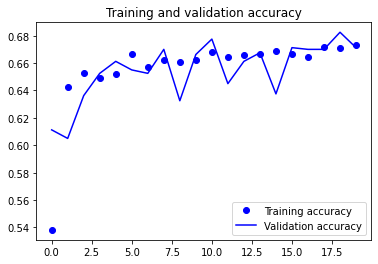

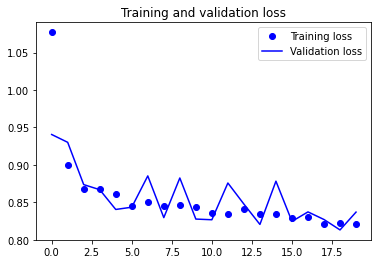

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp1.h5'))

28/28 [==============================] - 17s 406ms/step - loss: 0.7532 - accuracy: 0.7210
Test accuracy: 0.721
Test loss: 0.753
Classification report: 
              precision    recall  f1-score   support

           0     0.7290    0.5200    0.6070       150
           1     0.6824    0.7266    0.7038       139
           2     0.6935    0.7767    0.7327       300
           3     0.7685    0.7633    0.7659       300

    accuracy                         0.7210       889
   macro avg     0.7183    0.6967    0.7024       889
weighted avg     0.7230    0.7210    0.7182       889



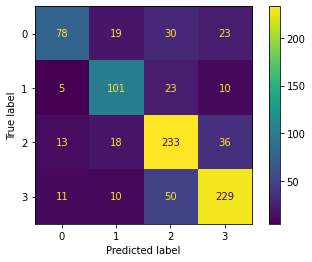

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

63576

### **Experiment 18] Global AVG Pooling + 2 Dense 64**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0   

In [ ]:
history = run_model(model, 'CheXNet_exp18', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 0.8582 - accuracy: 0.6568
Epoch 00001: val_loss improved from inf to 0.85563, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp18.h5
225/225 [==============================] - 56s 249ms/step - loss: 0.8582 - accuracy: 0.6568 - val_loss: 0.8556 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 0.8499 - accuracy: 0.6597
Epoch 00002: val_loss did not improve from 0.85563
225/225 [==============================] - 54s 238ms/step - loss: 0.8499 - accuracy: 0.6597 - val_loss: 0.8578 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 0.8535 - accuracy: 0.6583
Epoch 00003: val_loss improved from 0.85563 to 0.85276, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp18.h5
225/225 [==============================] - 55s 247ms/step - loss: 0.8535 - accuracy: 0.6583 - val_loss:

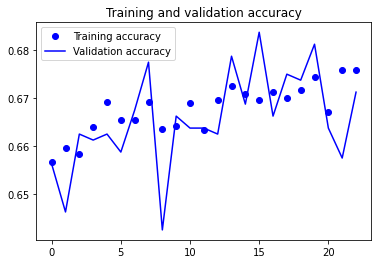

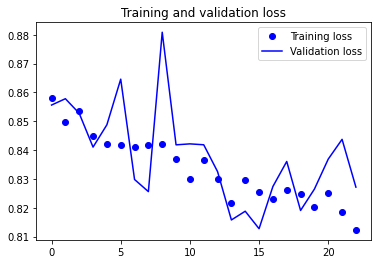

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp18.h5'))

28/28 [==============================] - 25s 571ms/step - loss: 0.7576 - accuracy: 0.7154
Test accuracy: 0.715
Test loss: 0.758
Classification report: 
              precision    recall  f1-score   support

           0     0.7419    0.4600    0.5679       150
           1     0.6481    0.7554    0.6977       139
           2     0.7034    0.7667    0.7337       300
           3     0.7557    0.7733    0.7644       300

    accuracy                         0.7154       889
   macro avg     0.7123    0.6888    0.6909       889
weighted avg     0.7189    0.7154    0.7104       889



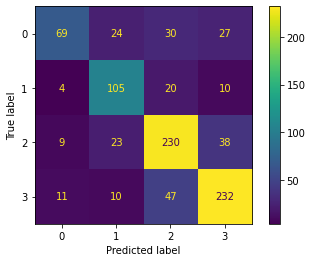

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

47757

### **Experiment 2] Global AVG Pooling + Dense 256**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                           

In [ ]:
history = run_model(model, 'CheXNet_exp2', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.0370 - accuracy: 0.5536
Epoch 00001: val_loss improved from inf to 0.88796, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp2.h5
225/225 [==============================] - 82s 298ms/step - loss: 1.0370 - accuracy: 0.5536 - val_loss: 0.8880 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.8876 - accuracy: 0.6412
Epoch 00002: val_loss improved from 0.88796 to 0.86959, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp2.h5
225/225 [==============================] - 58s 256ms/step - loss: 0.8876 - accuracy: 0.6412 - val_loss: 0.8696 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8745 - accuracy: 0.6536
Epoch 00003: val_loss did not improve from 0.86959
225/225 [==============================] - 55s 246ms/step - loss: 0.8745 - accuracy: 0.6536 - val_loss: 0

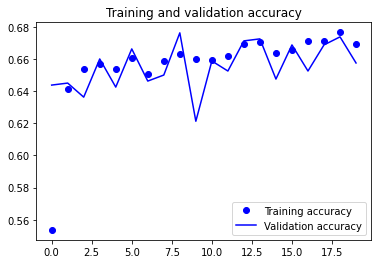

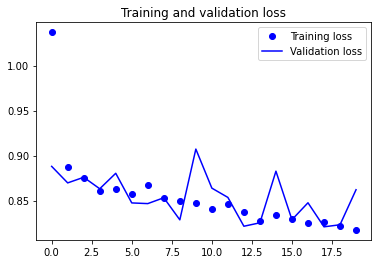

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp2.h5'))

28/28 [==============================] - 17s 422ms/step - loss: 0.7557 - accuracy: 0.7165
Test accuracy: 0.717
Test loss: 0.756
Classification report: 
              precision    recall  f1-score   support

           0     0.7449    0.4867    0.5887       150
           1     0.6797    0.7482    0.7123       139
           2     0.7285    0.7067    0.7174       300
           3     0.7147    0.8267    0.7666       300

    accuracy                         0.7165       889
   macro avg     0.7170    0.6921    0.6963       889
weighted avg     0.7190    0.7165    0.7115       889



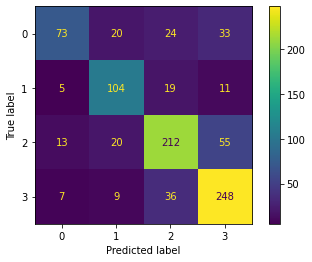

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

69965

### **Experiment 3] Global AVG Pooling + Dense 512**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                           

In [ ]:
history = run_model(model, 'CheXNet_exp3', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.0058 - accuracy: 0.5657
Epoch 00001: val_loss improved from inf to 0.93057, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp3.h5
225/225 [==============================] - 64s 256ms/step - loss: 1.0058 - accuracy: 0.5657 - val_loss: 0.9306 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.8972 - accuracy: 0.6373
Epoch 00002: val_loss improved from 0.93057 to 0.85572, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp3.h5
225/225 [==============================] - 57s 251ms/step - loss: 0.8972 - accuracy: 0.6373 - val_loss: 0.8557 - val_accuracy: 0.6550 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.6536
Epoch 00003: val_loss did not improve from 0.85572
225/225 [==============================] - 53s 236ms/step - loss: 0.8716 - accuracy: 0.6536 - val_loss: 0

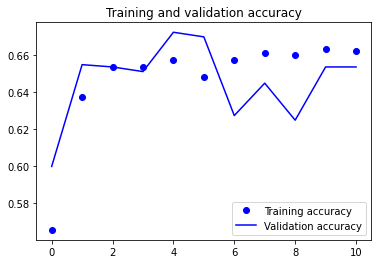

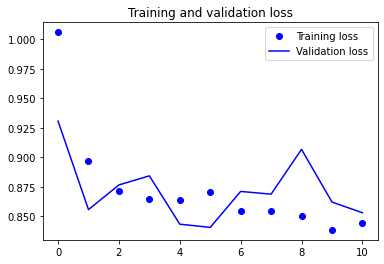

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp3.h5'))

28/28 [==============================] - 20s 406ms/step - loss: 0.7870 - accuracy: 0.7177
Test accuracy: 0.718
Test loss: 0.787
Classification report: 
              precision    recall  f1-score   support

           0     0.7423    0.4800    0.5830       150
           1     0.6993    0.7194    0.7092       139
           2     0.7300    0.7300    0.7300       300
           3     0.7077    0.8233    0.7612       300

    accuracy                         0.7177       889
   macro avg     0.7198    0.6882    0.6958       889
weighted avg     0.7198    0.7177    0.7125       889



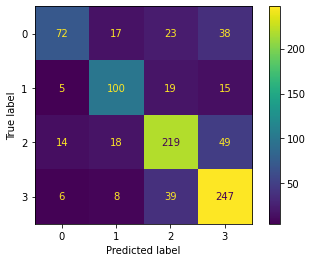

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

28642

### **Experiment 4] Global AVG Pooling + Dense 256 + Dense 256**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0   

In [ ]:
history = run_model(model, 'CheXNet_exp4', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.9813 - accuracy: 0.5926
Epoch 00001: val_loss improved from inf to 0.89743, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp4.h5
225/225 [==============================] - 129s 158ms/step - loss: 0.9813 - accuracy: 0.5926 - val_loss: 0.8974 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.8779 - accuracy: 0.6438
Epoch 00002: val_loss did not improve from 0.89743
225/225 [==============================] - 24s 108ms/step - loss: 0.8779 - accuracy: 0.6438 - val_loss: 0.9393 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.6455
Epoch 00003: val_loss improved from 0.89743 to 0.84207, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp4.h5
225/225 [==============================] - 25s 111ms/step - loss: 0.8856 - accuracy: 0.6455 - val_loss: 

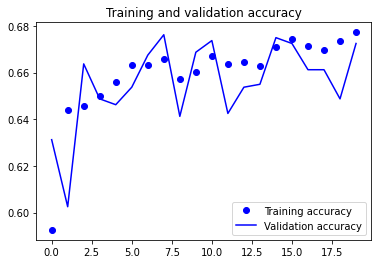

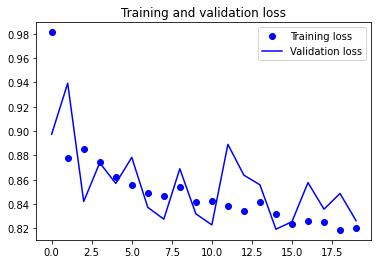

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp4.h5'))

28/28 [==============================] - 15s 346ms/step - loss: 0.7652 - accuracy: 0.7154
Test accuracy: 0.715
Test loss: 0.765
Classification report: 
              precision    recall  f1-score   support

           0     0.7738    0.4333    0.5556       150
           1     0.6522    0.7554    0.7000       139
           2     0.6833    0.7767    0.7270       300
           3     0.7690    0.7767    0.7728       300

    accuracy                         0.7154       889
   macro avg     0.7196    0.6855    0.6888       889
weighted avg     0.7226    0.7154    0.7093       889



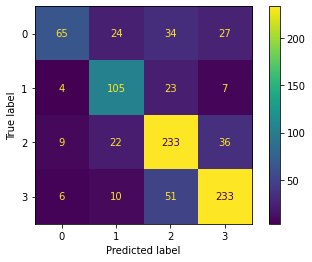

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 5] Global AVG Pooling + Dense 128 + Dense 64**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_exp5', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.0318 - accuracy: 0.5646
Epoch 00001: val_loss improved from inf to 0.98133, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp5.h5
225/225 [==============================] - 70s 265ms/step - loss: 1.0318 - accuracy: 0.5646 - val_loss: 0.9813 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.9038 - accuracy: 0.6360
Epoch 00002: val_loss improved from 0.98133 to 0.86682, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp5.h5
225/225 [==============================] - 57s 255ms/step - loss: 0.9038 - accuracy: 0.6360 - val_loss: 0.8668 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8661 - accuracy: 0.6611
Epoch 00003: val_loss improved from 0.86682 to 0.83692, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp5.h5
225/225 [==============

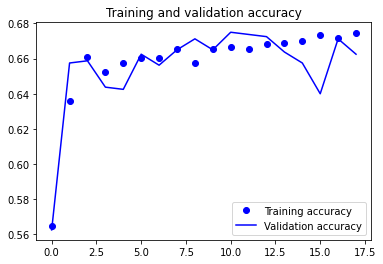

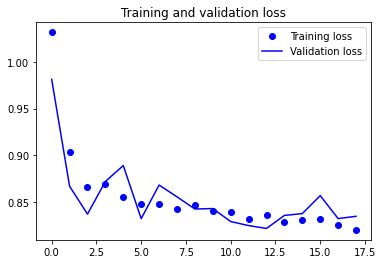

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp2.h5'))

28/28 [==============================] - 8s 221ms/step - loss: 0.7557 - accuracy: 0.7165
Test accuracy: 0.717
Test loss: 0.756
Classification report: 
              precision    recall  f1-score   support

           0     0.7449    0.4867    0.5887       150
           1     0.6797    0.7482    0.7123       139
           2     0.7285    0.7067    0.7174       300
           3     0.7147    0.8267    0.7666       300

    accuracy                         0.7165       889
   macro avg     0.7170    0.6921    0.6963       889
weighted avg     0.7190    0.7165    0.7115       889



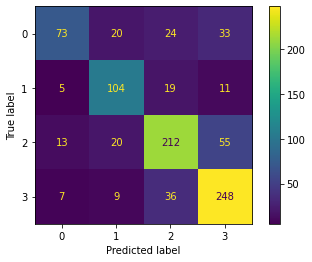

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

19877

### **Experiment 6] Flatten + Dense 64**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0     

In [ ]:
history = run_model(model, 'CheXNet_exp6', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.4679 - accuracy: 0.5661
Epoch 00001: val_loss improved from inf to 1.01740, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp6.h5
225/225 [==============================] - 72s 251ms/step - loss: 1.4679 - accuracy: 0.5661 - val_loss: 1.0174 - val_accuracy: 0.6125 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.9959 - accuracy: 0.6334
Epoch 00002: val_loss improved from 1.01740 to 0.93620, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp6.h5
225/225 [==============================] - 56s 247ms/step - loss: 0.9959 - accuracy: 0.6334 - val_loss: 0.9362 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.9323 - accuracy: 0.6515
Epoch 00003: val_loss did not improve from 0.93620
225/225 [==============================] - 53s 237ms/step - loss: 0.9323 - accuracy: 0.6515 - val_loss: 0

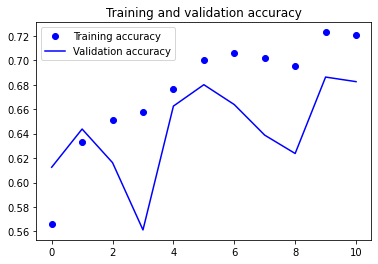

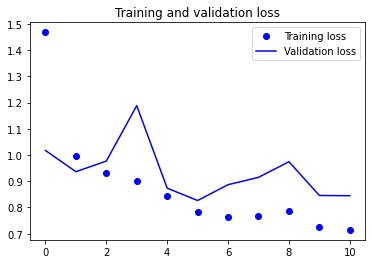

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp6.h5'))

28/28 [==============================] - 8s 215ms/step - loss: 0.7602 - accuracy: 0.7132
Test accuracy: 0.713
Test loss: 0.760
Classification report: 
              precision    recall  f1-score   support

           0     0.7363    0.4467    0.5560       150
           1     0.7360    0.6619    0.6970       139
           2     0.6553    0.8300    0.7324       300
           3     0.7713    0.7533    0.7622       300

    accuracy                         0.7132       889
   macro avg     0.7247    0.6730    0.6869       889
weighted avg     0.7207    0.7132    0.7071       889



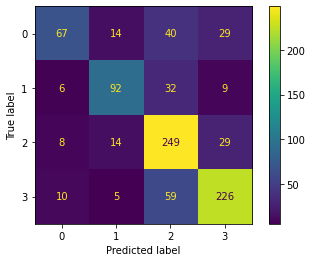

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

28867

### **Experiment 7] Global AVG Pooling + 2 Dense 128**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_exp7', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.0258 - accuracy: 0.5528
Epoch 00001: val_loss improved from inf to 0.89761, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp7.h5
225/225 [==============================] - 35s 117ms/step - loss: 1.0258 - accuracy: 0.5528 - val_loss: 0.8976 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.9059 - accuracy: 0.6340
Epoch 00002: val_loss improved from 0.89761 to 0.88087, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp7.h5
225/225 [==============================] - 25s 113ms/step - loss: 0.9059 - accuracy: 0.6340 - val_loss: 0.8809 - val_accuracy: 0.6550 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8824 - accuracy: 0.6470
Epoch 00003: val_loss improved from 0.88087 to 0.84248, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp7.h5
225/225 [==============

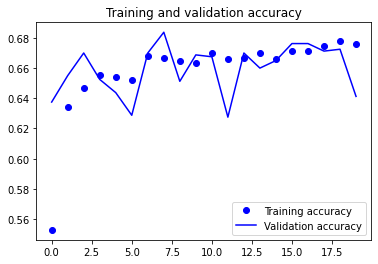

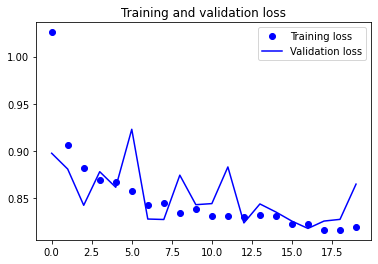

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp7.h5'))

28/28 [==============================] - 4s 96ms/step - loss: 0.7608 - accuracy: 0.7132
Test accuracy: 0.713
Test loss: 0.761
Classification report: 
              precision    recall  f1-score   support

           0     0.7875    0.4200    0.5478       150
           1     0.6624    0.7482    0.7027       139
           2     0.7063    0.7533    0.7290       300
           3     0.7259    0.8033    0.7627       300

    accuracy                         0.7132       889
   macro avg     0.7205    0.6812    0.6856       889
weighted avg     0.7197    0.7132    0.7057       889



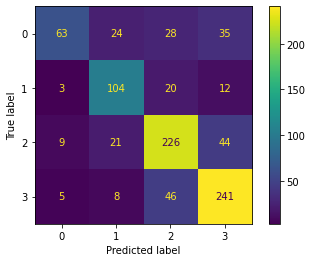

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 8] Flatten + Dense 128**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0     

In [ ]:
history = run_model(model, 'CheXNet_exp8', train_set=train_set, val_set=val_set, epochs=50, patience=13, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.7641 - accuracy: 0.3300
Epoch 00001: val_loss improved from inf to 1.36287, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp8.h5
225/225 [==============================] - 70s 252ms/step - loss: 1.7641 - accuracy: 0.3300 - val_loss: 1.3629 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.3090 - accuracy: 0.3338
Epoch 00002: val_loss improved from 1.36287 to 1.23256, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp8.h5
225/225 [==============================] - 55s 245ms/step - loss: 1.3090 - accuracy: 0.3338 - val_loss: 1.2326 - val_accuracy: 0.3462 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.2226 - accuracy: 0.3556
Epoch 00003: val_loss improved from 1.23256 to 1.16905, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp8.h5
225/225 [==============

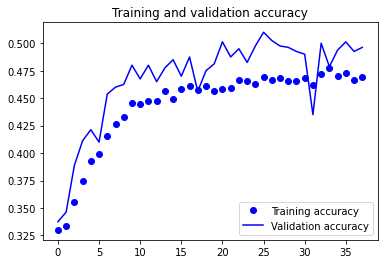

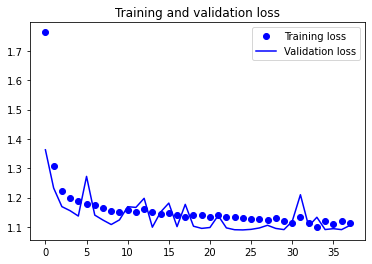

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp8.h5'))

28/28 [==============================] - 8s 213ms/step - loss: 1.0630 - accuracy: 0.5062
Test accuracy: 0.506
Test loss: 1.063
Classification report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       150
           1     0.0000    0.0000    0.0000       139
           2     0.3981    0.6833    0.5031       300
           3     0.6551    0.8167    0.7270       300

    accuracy                         0.5062       889
   macro avg     0.2633    0.3750    0.3075       889
weighted avg     0.3554    0.5062    0.4151       889



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


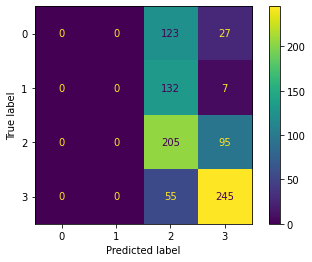

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

20657

### **Experiment 9] Global AVG Pooling + 3 Dense 128**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_exp9', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.0381 - accuracy: 0.5489
Epoch 00001: val_loss improved from inf to 0.99044, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp9.h5
225/225 [==============================] - 36s 121ms/step - loss: 1.0381 - accuracy: 0.5489 - val_loss: 0.9904 - val_accuracy: 0.5775 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.8987 - accuracy: 0.6430
Epoch 00002: val_loss improved from 0.99044 to 0.84699, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp9.h5
225/225 [==============================] - 26s 114ms/step - loss: 0.8987 - accuracy: 0.6430 - val_loss: 0.8470 - val_accuracy: 0.6587 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8866 - accuracy: 0.6476
Epoch 00003: val_loss did not improve from 0.84699
225/225 [==============================] - 24s 108ms/step - loss: 0.8866 - accuracy: 0.6476 - val_loss: 0

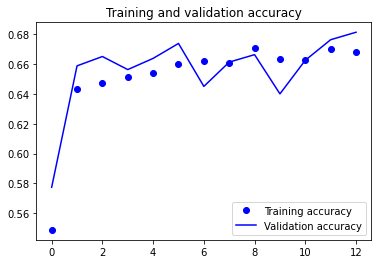

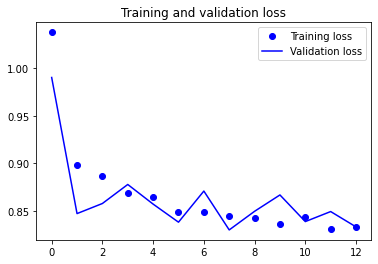

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp9.h5'))

28/28 [==============================] - 4s 96ms/step - loss: 0.7588 - accuracy: 0.7199
Test accuracy: 0.720
Test loss: 0.759
Classification report: 
              precision    recall  f1-score   support

           0     0.6944    0.5000    0.5814       150
           1     0.6645    0.7410    0.7007       139
           2     0.7309    0.7333    0.7321       300
           3     0.7446    0.8067    0.7744       300

    accuracy                         0.7199       889
   macro avg     0.7086    0.6953    0.6971       889
weighted avg     0.7190    0.7199    0.7160       889



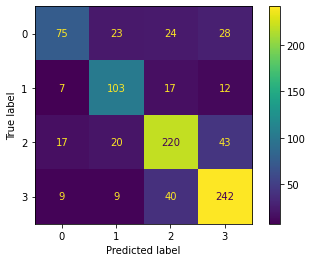

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

84906

### **Experiment 10] Global AVG Pooling + Dense 256 + Dense 128**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_exp10', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.5695
Epoch 00001: val_loss improved from inf to 0.90687, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp10.h5
225/225 [==============================] - 78s 262ms/step - loss: 1.0037 - accuracy: 0.5695 - val_loss: 0.9069 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.8958 - accuracy: 0.6352
Epoch 00002: val_loss improved from 0.90687 to 0.88730, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp10.h5
225/225 [==============================] - 57s 254ms/step - loss: 0.8958 - accuracy: 0.6352 - val_loss: 0.8873 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8853 - accuracy: 0.6479
Epoch 00003: val_loss did not improve from 0.88730
225/225 [==============================] - 55s 246ms/step - loss: 0.8853 - accuracy: 0.6479 - val_loss:

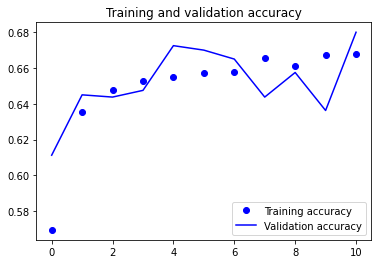

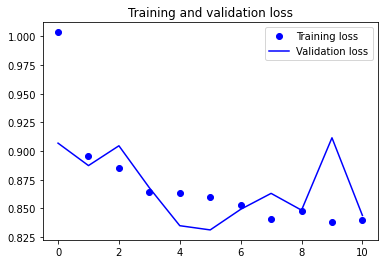

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp10.h5'))

28/28 [==============================] - 8s 221ms/step - loss: 0.7650 - accuracy: 0.7064
Test accuracy: 0.706
Test loss: 0.765
Classification report: 
              precision    recall  f1-score   support

           0     0.6964    0.5200    0.5954       150
           1     0.6688    0.7554    0.7095       139
           2     0.6695    0.7767    0.7191       300
           3     0.7794    0.7067    0.7413       300

    accuracy                         0.7064       889
   macro avg     0.7035    0.6897    0.6913       889
weighted avg     0.7110    0.7064    0.7042       889



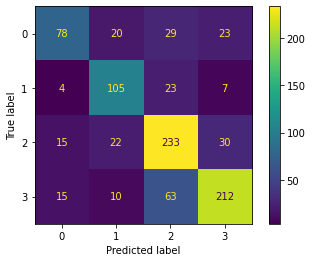

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

26099

### **Experiment 11] Global AVG Pooling + 3 Dense 128 + 3 Dropout 0.25**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_exp11', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.1679 - accuracy: 0.4554
Epoch 00001: val_loss improved from inf to 0.99029, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp11.h5
225/225 [==============================] - 37s 118ms/step - loss: 1.1679 - accuracy: 0.4554 - val_loss: 0.9903 - val_accuracy: 0.5738 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.0165 - accuracy: 0.5749
Epoch 00002: val_loss improved from 0.99029 to 0.92914, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp11.h5
225/225 [==============================] - 26s 115ms/step - loss: 1.0165 - accuracy: 0.5749 - val_loss: 0.9291 - val_accuracy: 0.6338 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.9839 - accuracy: 0.5938
Epoch 00003: val_loss did not improve from 0.92914
225/225 [==============================] - 24s 108ms/step - loss: 0.9839 - accuracy: 0.5938 - val_loss:

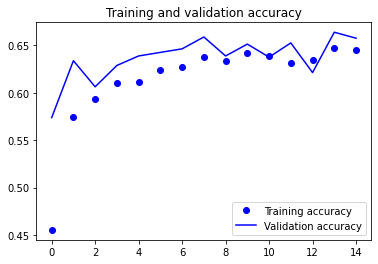

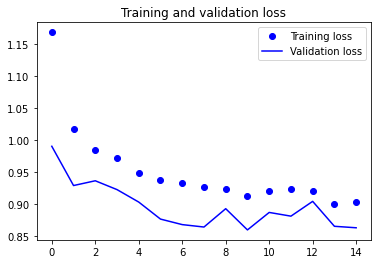

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp11.h5'))

28/28 [==============================] - 5s 98ms/step - loss: 0.8062 - accuracy: 0.7030
Test accuracy: 0.703
Test loss: 0.806
Classification report: 
              precision    recall  f1-score   support

           0     0.6667    0.5333    0.5926       150
           1     0.6646    0.7698    0.7133       139
           2     0.6744    0.7733    0.7205       300
           3     0.7803    0.6867    0.7305       300

    accuracy                         0.7030       889
   macro avg     0.6965    0.6908    0.6892       889
weighted avg     0.7073    0.7030    0.7012       889



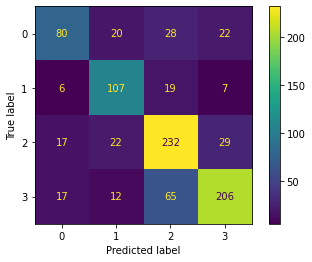

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 12] Data Augumentation + Global AVG Pooling + 2 Dense 128**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.densenet.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037

In [ ]:
history = run_model(model, 'CheXNet_exp12', train_set=train_set, val_set=val_set, epochs=50, patience=13, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.2751 - accuracy: 0.3869
Epoch 00001: val_loss improved from inf to 1.05607, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp12.h5
225/225 [==============================] - 174s 304ms/step - loss: 1.2751 - accuracy: 0.3869 - val_loss: 1.0561 - val_accuracy: 0.4825 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.2056 - accuracy: 0.4479
Epoch 00002: val_loss improved from 1.05607 to 0.94227, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp12.h5
225/225 [==============================] - 56s 250ms/step - loss: 1.2056 - accuracy: 0.4479 - val_loss: 0.9423 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.1924 - accuracy: 0.4707
Epoch 00003: val_loss improved from 0.94227 to 0.93389, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp12.h5
225/225 [==========

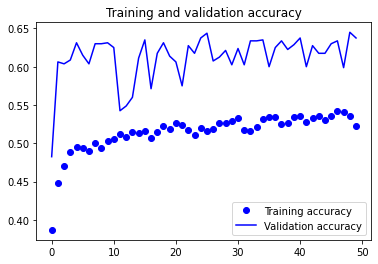

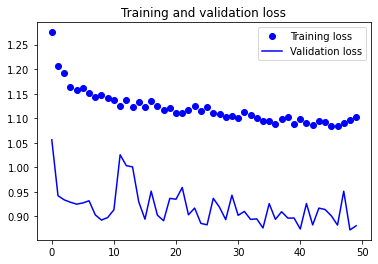

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp12.h5'))

28/28 [==============================] - 17s 401ms/step - loss: 0.8400 - accuracy: 0.6738
Test accuracy: 0.674
Test loss: 0.840
Classification report: 
              precision    recall  f1-score   support

           0     0.7174    0.4400    0.5455       150
           1     0.6358    0.7914    0.7051       139
           2     0.6169    0.8267    0.7066       300
           3     0.7883    0.5833    0.6705       300

    accuracy                         0.6738       889
   macro avg     0.6896    0.6603    0.6569       889
weighted avg     0.6947    0.6738    0.6670       889



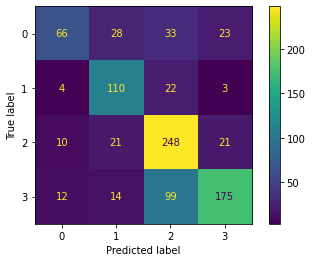

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 13] Data Augumentation + Global AVG Pooling + 2 Dense 256 + Dense 128**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.densenet.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        703750

In [ ]:
history = run_model(model, 'CheXNet_exp13', train_set=train_set, val_set=val_set, epochs=50, patience=13, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.2893 - accuracy: 0.3823
Epoch 00001: val_loss improved from inf to 1.11238, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp13.h5
225/225 [==============================] - 181s 310ms/step - loss: 1.2893 - accuracy: 0.3823 - val_loss: 1.1124 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.2141 - accuracy: 0.4447
Epoch 00002: val_loss improved from 1.11238 to 0.99115, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp13.h5
225/225 [==============================] - 57s 252ms/step - loss: 1.2141 - accuracy: 0.4447 - val_loss: 0.9912 - val_accuracy: 0.5825 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.1976 - accuracy: 0.4653
Epoch 00003: val_loss improved from 0.99115 to 0.92781, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp13.h5
225/225 [==========

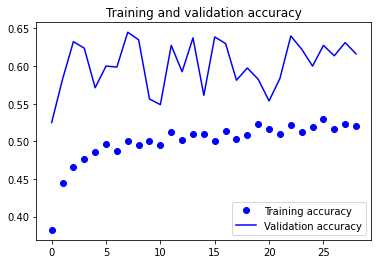

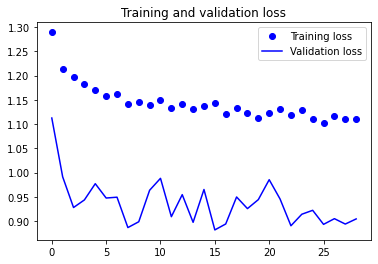

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp13.h5'))

28/28 [==============================] - 8s 212ms/step - loss: 0.8355 - accuracy: 0.6749
Test accuracy: 0.675
Test loss: 0.836
Classification report: 
              precision    recall  f1-score   support

           0     0.6952    0.4867    0.5725       150
           1     0.6279    0.7770    0.6945       139
           2     0.6361    0.7867    0.7034       300
           3     0.7593    0.6100    0.6765       300

    accuracy                         0.6749       889
   macro avg     0.6796    0.6651    0.6618       889
weighted avg     0.6864    0.6749    0.6709       889



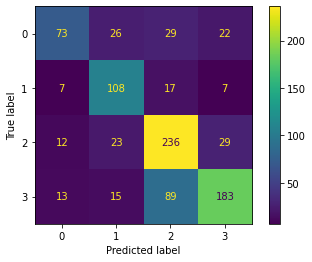

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

16410

### **Experiment 15] Data Augumentation + Global AVG Pooling + Dense 512 + Dense 256 + Dense 128**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.densenet.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037

In [ ]:
history = run_model(model, 'CheXNet_exp15', train_set=train_set, val_set=val_set, epochs=50, patience=20, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 2.0063 - accuracy: 0.3906
Epoch 00001: val_loss improved from inf to 0.90779, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp15.h5
225/225 [==============================] - 189s 321ms/step - loss: 2.0063 - accuracy: 0.3906 - val_loss: 0.9078 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.2015 - accuracy: 0.4772
Epoch 00002: val_loss did not improve from 0.90779
225/225 [==============================] - 59s 263ms/step - loss: 1.2015 - accuracy: 0.4772 - val_loss: 0.9840 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.1797 - accuracy: 0.4876
Epoch 00003: val_loss did not improve from 0.90779
225/225 [==============================] - 59s 262ms/step - loss: 1.1797 - accuracy: 0.4876 - val_loss: 1.1004 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 4/50
225/225 [==================

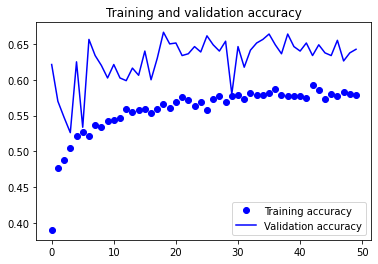

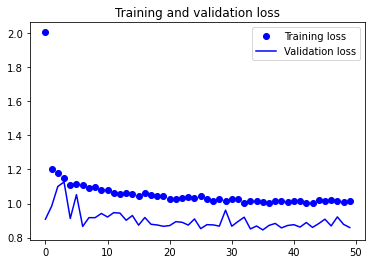

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp15.h5'))

28/28 [==============================] - 18s 432ms/step - loss: 0.8413 - accuracy: 0.6614
Test accuracy: 0.661
Test loss: 0.841
Classification report: 
              precision    recall  f1-score   support

           0     0.6293    0.4867    0.5489       150
           1     0.6547    0.6547    0.6547       139
           2     0.6144    0.7967    0.6938       300
           3     0.7551    0.6167    0.6789       300

    accuracy                         0.6614       889
   macro avg     0.6634    0.6387    0.6441       889
weighted avg     0.6707    0.6614    0.6582       889



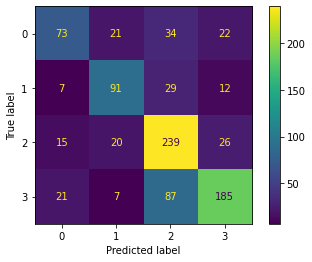

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

4470

### **Experiment 16] Global AVG Pooling + Dense 1024 + Dense 512 + Dense 256**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_exp16', train_set=train_set, val_set=val_set, epochs=50, patience=13, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.0465 - accuracy: 0.5477
Epoch 00001: val_loss improved from inf to 0.91921, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp16.h5
225/225 [==============================] - 80s 278ms/step - loss: 1.0465 - accuracy: 0.5477 - val_loss: 0.9192 - val_accuracy: 0.6075 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 0.9120 - accuracy: 0.6322
Epoch 00002: val_loss improved from 0.91921 to 0.90631, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp16.h5
225/225 [==============================] - 57s 255ms/step - loss: 0.9120 - accuracy: 0.6322 - val_loss: 0.9063 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 0.8997 - accuracy: 0.6456
Epoch 00003: val_loss improved from 0.90631 to 0.89107, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp16.h5
225/225 [===========

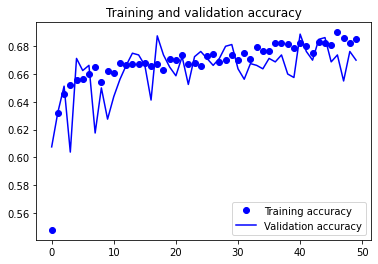

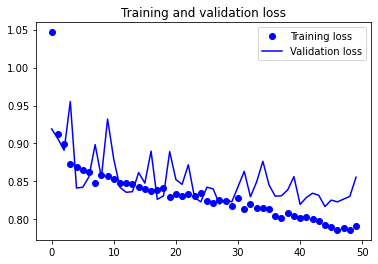

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp16.h5'))

28/28 [==============================] - 9s 223ms/step - loss: 0.7473 - accuracy: 0.7064
Test accuracy: 0.706
Test loss: 0.747
Classification report: 
              precision    recall  f1-score   support

           0     0.7019    0.4867    0.5748       150
           1     0.6519    0.7410    0.6936       139
           2     0.6725    0.7733    0.7194       300
           3     0.7801    0.7333    0.7560       300

    accuracy                         0.7064       889
   macro avg     0.7016    0.6836    0.6859       889
weighted avg     0.7106    0.7064    0.7033       889



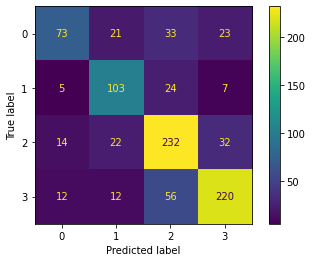

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

4510

### **Experiment 17] Global AVG Pooling + Dense 1024 + Dense 512 + Dense 256 + Regularization L2**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = layers.Dense(512, activation='relu', kernel_regularizer='l2')(x)
x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax', kernel_regularizer='l2')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_exp17', train_set=train_set, val_set=val_set, epochs=50, patience=13, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 3.7652 - accuracy: 0.5443
Epoch 00001: val_loss improved from inf to 1.35553, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp17.h5
225/225 [==============================] - 76s 273ms/step - loss: 3.7652 - accuracy: 0.5443 - val_loss: 1.3555 - val_accuracy: 0.5763 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.2131 - accuracy: 0.6115
Epoch 00002: val_loss improved from 1.35553 to 1.11149, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp17.h5
225/225 [==============================] - 53s 237ms/step - loss: 1.2131 - accuracy: 0.6115 - val_loss: 1.1115 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.1276 - accuracy: 0.6212
Epoch 00003: val_loss improved from 1.11149 to 1.06675, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_exp17.h5
225/225 [===========

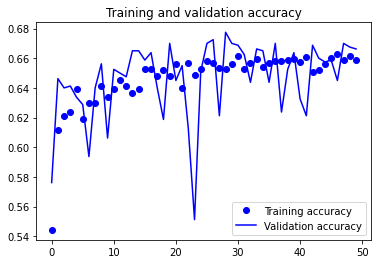

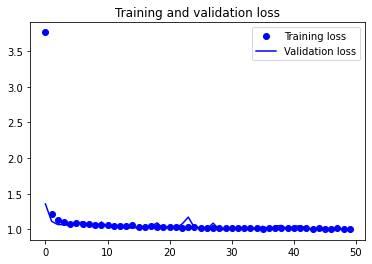

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_exp17.h5'))

28/28 [==============================] - 8s 209ms/step - loss: 0.9474 - accuracy: 0.7075
Test accuracy: 0.708
Test loss: 0.947
Classification report: 
              precision    recall  f1-score   support

           0     0.7619    0.4267    0.5470       150
           1     0.6645    0.7266    0.6942       139
           2     0.6844    0.7733    0.7261       300
           3     0.7389    0.7733    0.7557       300

    accuracy                         0.7075       889
   macro avg     0.7124    0.6750    0.6808       889
weighted avg     0.7127    0.7075    0.7009       889



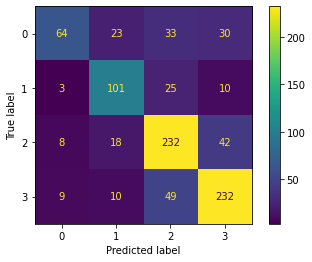

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

64579

## **Fine Tune CheXNet**

In [ ]:
conv_base.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [9]:
def get_model_to_fine_tune(model, num_of_layers=1, model_name='model_1', verbose=False):
  if num_of_layers < 1:
      num_of_layers = 1

  res = tf.keras.models.load_model(os.path.join(MODELS_PATH, f'{model}.h5'))
  res.trainable = True

  conv_layers = [layer.name for layer in res.get_layer(model_name).layers if ('_conv' in layer.name or 'bn' in layer.name)]

  layer_names = conv_layers[-num_of_layers:]
  if verbose:
    print(layer_names)

  set_trainable = False
  for layer in res.get_layer(model_name).layers:
    if layer.name in layer_names:
      set_trainable = True
    else:
      set_trainable = False

    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
  
  if verbose:
    for i, layer in enumerate(res.get_layer(model_name).layers):
      print(i, layer.name, layer.trainable)

  return res

In [ ]:
no_data_aug_model = 'CheXNet_exp7'

In [ ]:
data_aug_model = 'CheXNet_exp12'

In [ ]:
no_data_aug_model_2 = 'CheXNet_exp18'

### **FineTune 1] Unfreeze Last Block + Global AVG Pooling + 2 Dense 128**

In [ ]:
model = get_model_to_fine_tune(no_data_aug_model, num_of_layers=5, verbose=True)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

['conv5_block15_2_conv', 'conv5_block16_0_bn', 'conv5_block16_1_conv', 'conv5_block16_1_bn', 'conv5_block16_2_conv', 'bn']
0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_

In [ ]:
history = run_model(model, 'CheXNet_fine_tune_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=13, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 0.8209 - accuracy: 0.6738
Epoch 00001: val_loss improved from inf to 0.81840, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_fine_tune_exp1.h5
225/225 [==============================] - 76s 267ms/step - loss: 0.8209 - accuracy: 0.6738 - val_loss: 0.8184 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 0.8183 - accuracy: 0.6705
Epoch 00002: val_loss did not improve from 0.81840
225/225 [==============================] - 57s 251ms/step - loss: 0.8183 - accuracy: 0.6705 - val_loss: 0.8187 - val_accuracy: 0.6762 - lr: 1.0000e-05
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.6713
Epoch 00003: val_loss did not improve from 0.81840
225/225 [==============================] - 56s 251ms/step - loss: 0.8181 - accuracy: 0.6713 - val_loss: 0.8185 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 4/50
225/225

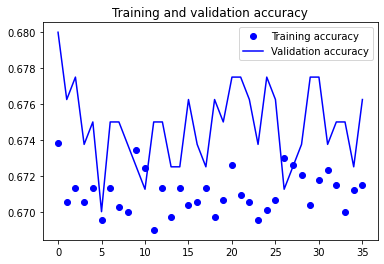

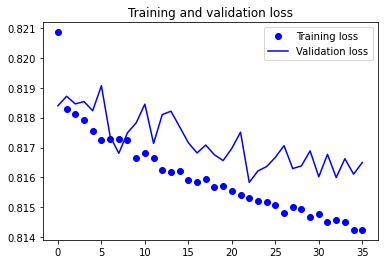

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_fine_tune_exp1.h5'))

28/28 [==============================] - 9s 222ms/step - loss: 0.7461 - accuracy: 0.7222
Test accuracy: 0.722
Test loss: 0.746
Classification report: 
              precision    recall  f1-score   support

           0     0.7282    0.5000    0.5929       150
           1     0.6800    0.7338    0.7059       139
           2     0.7094    0.7567    0.7323       300
           3     0.7532    0.7933    0.7727       300

    accuracy                         0.7222       889
   macro avg     0.7177    0.6960    0.7009       889
weighted avg     0.7227    0.7222    0.7183       889



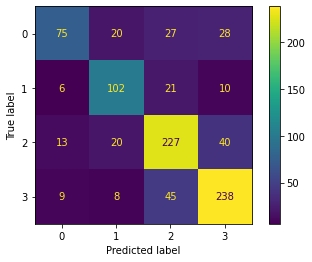

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 2] Unfreeze Last Block + Data Augumentation + Global AVG Pooling + 2 Dense 128**

In [ ]:
model = get_model_to_fine_tune(data_aug_model, num_of_layers=6)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272

In [ ]:
history = run_model(model, 'CheXNet_fine_tune_exp2', train_set=train_set, val_set=val_set, epochs=50, patience=13, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.5282
Epoch 00001: val_loss improved from inf to 0.91314, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_fine_tune_exp2.h5
225/225 [==============================] - 80s 252ms/step - loss: 1.1124 - accuracy: 0.5282 - val_loss: 0.9131 - val_accuracy: 0.6288 - lr: 1.0000e-05
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.1015 - accuracy: 0.5374
Epoch 00002: val_loss did not improve from 0.91314
225/225 [==============================] - 53s 235ms/step - loss: 1.1015 - accuracy: 0.5374 - val_loss: 0.9394 - val_accuracy: 0.6175 - lr: 1.0000e-05
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.1002 - accuracy: 0.5357
Epoch 00003: val_loss did not improve from 0.91314
225/225 [==============================] - 53s 235ms/step - loss: 1.1002 - accuracy: 0.5357 - val_loss: 0.9414 - val_accuracy: 0.6187 - lr: 1.0000e-05
Epoch 4/50
225/225

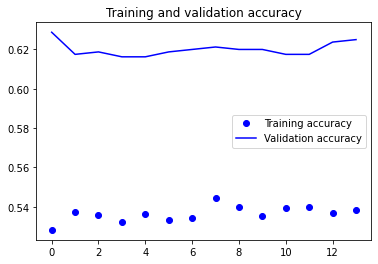

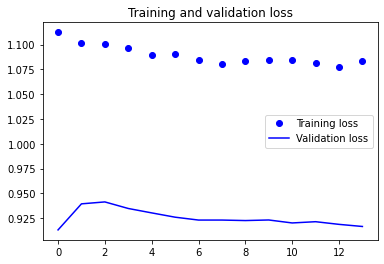

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_fine_tune_exp2.h5'))

28/28 [==============================] - 8s 205ms/step - loss: 0.8639 - accuracy: 0.6592
Test accuracy: 0.659
Test loss: 0.864
Classification report: 
              precision    recall  f1-score   support

           0     0.6637    0.5000    0.5703       150
           1     0.6446    0.7698    0.7016       139
           2     0.5981    0.8233    0.6928       300
           3     0.7970    0.5233    0.6318       300

    accuracy                         0.6592       889
   macro avg     0.6758    0.6541    0.6492       889
weighted avg     0.6835    0.6592    0.6529       889



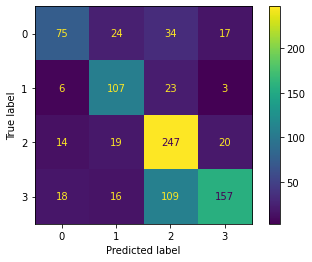

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 3] Unfreeze Last Block + Global AVG Pooling + 2 Dense 64**

In [ ]:
model = get_model_to_fine_tune(no_data_aug_model_2, num_of_layers=5)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0   

In [ ]:
history = run_model(model, 'CheXNet_fine_tune_exp3', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 0.8163 - accuracy: 0.6770
Epoch 00001: val_loss improved from inf to 0.81211, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_fine_tune_exp3.h5
225/225 [==============================] - 119s 251ms/step - loss: 0.8163 - accuracy: 0.6770 - val_loss: 0.8121 - val_accuracy: 0.6762 - lr: 1.0000e-05
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 0.8147 - accuracy: 0.6790
Epoch 00002: val_loss did not improve from 0.81211
225/225 [==============================] - 53s 238ms/step - loss: 0.8147 - accuracy: 0.6790 - val_loss: 0.8124 - val_accuracy: 0.6700 - lr: 1.0000e-05
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 0.8139 - accuracy: 0.6780
Epoch 00003: val_loss did not improve from 0.81211
225/225 [==============================] - 53s 237ms/step - loss: 0.8139 - accuracy: 0.6780 - val_loss: 0.8138 - val_accuracy: 0.6675 - lr: 1.0000e-05
Epoch 4/50
225/22

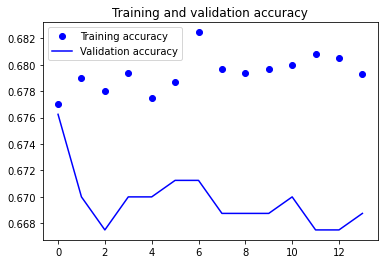

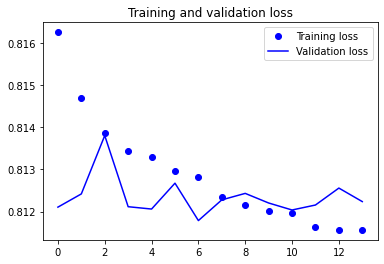

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_fine_tune_exp3.h5'))

28/28 [==============================] - 8s 216ms/step - loss: 0.7463 - accuracy: 0.7199
Test accuracy: 0.720
Test loss: 0.746
Classification report: 
              precision    recall  f1-score   support

           0     0.6937    0.5133    0.5900       150
           1     0.6821    0.7410    0.7103       139
           2     0.7170    0.7600    0.7379       300
           3     0.7508    0.7733    0.7619       300

    accuracy                         0.7199       889
   macro avg     0.7109    0.6969    0.7000       889
weighted avg     0.7190    0.7199    0.7167       889



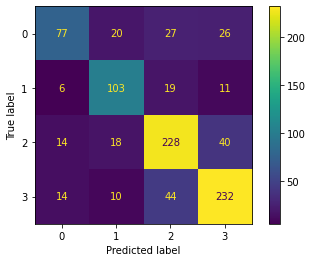

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 4] Unfreeze Last 2 Blocks + Global AVG Pooling + 2 Dense 64**

In [ ]:
model = get_model_to_fine_tune(no_data_aug_model_2, num_of_layers=9)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0   

In [ ]:
history = run_model(model, 'CheXNet_fine_tune_exp4', train_set=train_set, val_set=val_set, epochs=50, patience=15, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 0.8160 - accuracy: 0.6807
Epoch 00001: val_loss improved from inf to 0.81202, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_fine_tune_exp4.h5
225/225 [==============================] - 72s 256ms/step - loss: 0.8160 - accuracy: 0.6807 - val_loss: 0.8120 - val_accuracy: 0.6700 - lr: 1.0000e-05
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 0.8144 - accuracy: 0.6769
Epoch 00002: val_loss improved from 0.81202 to 0.81181, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_fine_tune_exp4.h5
225/225 [==============================] - 56s 249ms/step - loss: 0.8144 - accuracy: 0.6769 - val_loss: 0.8118 - val_accuracy: 0.6700 - lr: 1.0000e-05
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 0.8141 - accuracy: 0.6775
Epoch 00003: val_loss improved from 0.81181 to 0.81144, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_fin

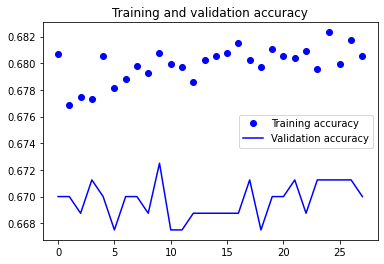

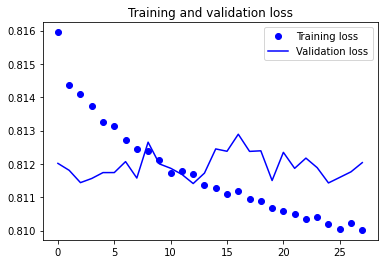

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_fine_tune_exp4.h5'))

28/28 [==============================] - 8s 215ms/step - loss: 0.7452 - accuracy: 0.7188
Test accuracy: 0.719
Test loss: 0.745
Classification report: 
              precision    recall  f1-score   support

           0     0.7130    0.5133    0.5969       150
           1     0.6800    0.7338    0.7059       139
           2     0.7077    0.7667    0.7360       300
           3     0.7516    0.7667    0.7591       300

    accuracy                         0.7188       889
   macro avg     0.7131    0.6951    0.6995       889
weighted avg     0.7191    0.7188    0.7156       889



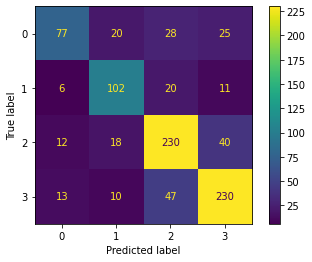

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

# **New Dataset**

In [ ]:
!unzip /content/drive/MyDrive/CIDL_Group/ULTIMO_DATASET_VALE.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00007336_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00021327_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00022325_001.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00008899_009.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00028039_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00030460_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00022572_023.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00021145_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/

In [ ]:
UPDATED_DATASET = '/content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET'
TRAIN_PATH = os.path.join(UPDATED_DATASET, 'train')
VAL_PATH = os.path.join(UPDATED_DATASET, 'val')
TEST_PATH = os.path.join(UPDATED_DATASET, 'test')

CLASSES = os.listdir(TRAIN_PATH)

100%|██████████| 4/4 [00:00<00:00, 64.94it/s]


Number of No Finding: 3240, proportion: 0.2907655030063717
Number of Atelectasis: 2384, proportion: 0.2139459750516019
Number of Effusion: 2279, proportion: 0.20452301893565467
Number of Infiltration: 3240, proportion: 0.2907655030063717


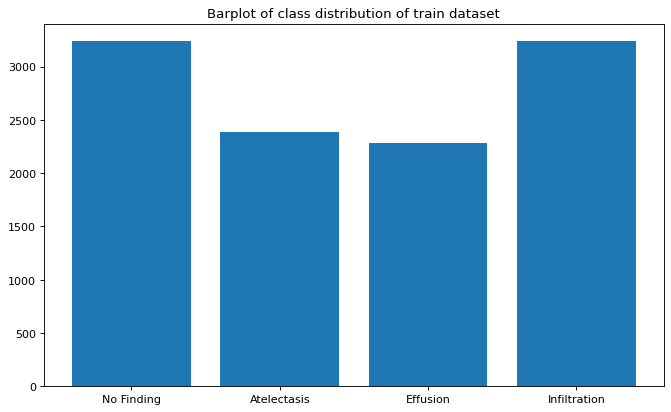

100%|██████████| 4/4 [00:00<00:00, 345.94it/s]


Number of No Finding: 360, proportion: 0.2786377708978328
Number of Atelectasis: 289, proportion: 0.2236842105263158
Number of Effusion: 283, proportion: 0.21904024767801858
Number of Infiltration: 360, proportion: 0.2786377708978328


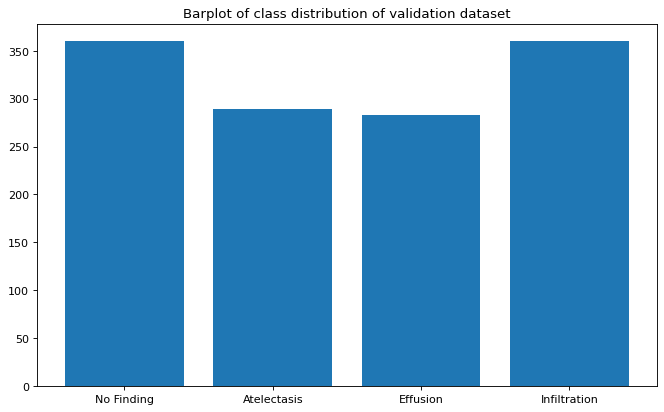

100%|██████████| 4/4 [00:00<00:00, 376.11it/s]


Number of No Finding: 400, proportion: 0.27816411682892905
Number of Atelectasis: 324, proportion: 0.22531293463143254
Number of Effusion: 314, proportion: 0.21835883171070933
Number of Infiltration: 400, proportion: 0.27816411682892905


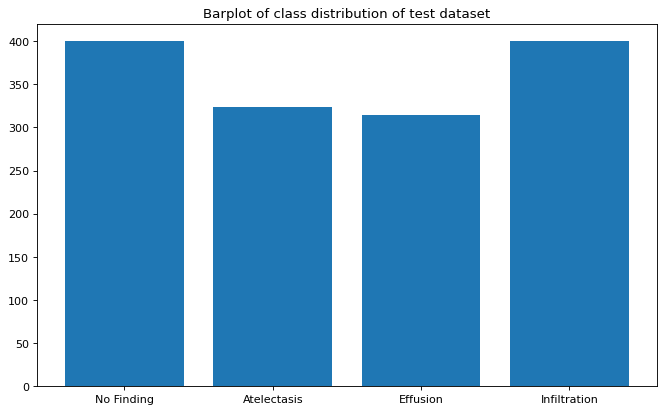

In [ ]:
plot_class_distribution(TRAIN_PATH, 'train')
plot_class_distribution(VAL_PATH, 'validation')
plot_class_distribution(TEST_PATH, 'test')

In [ ]:
train_set = load_training_set(IMAGE_SIZE, BATCH_SIZE)
train_set_no_shuffle = load_training_set(IMAGE_SIZE, BATCH_SIZE, shuffle=False)
val_set = load_validation_set(IMAGE_SIZE, BATCH_SIZE)
test_set = load_test_set(IMAGE_SIZE, BATCH_SIZE)

Found 11143 files belonging to 4 classes.
Found 11143 files belonging to 4 classes.
Found 1292 files belonging to 4 classes.
Found 1438 files belonging to 4 classes.


### **Experiment 1] Global AVG Pooling + 2 Dense 64**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_updated_dataset_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=9, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.0156 - accuracy: 0.5725
Epoch 00001: val_loss improved from inf to 0.88122, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_updated_dataset_exp1.h5
349/349 [==============================] - 258s 287ms/step - loss: 1.0156 - accuracy: 0.5725 - val_loss: 0.8812 - val_accuracy: 0.6618 - lr: 0.0010
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.8817 - accuracy: 0.6524
Epoch 00002: val_loss improved from 0.88122 to 0.85307, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_updated_dataset_exp1.h5
349/349 [==============================] - 87s 249ms/step - loss: 0.8817 - accuracy: 0.6524 - val_loss: 0.8531 - val_accuracy: 0.6780 - lr: 0.0010
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.8852 - accuracy: 0.6512
Epoch 00003: val_loss did not improve from 0.85307
349/349 [==============================] - 84s 241ms/step - loss: 0.8852

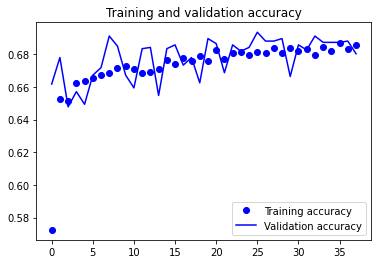

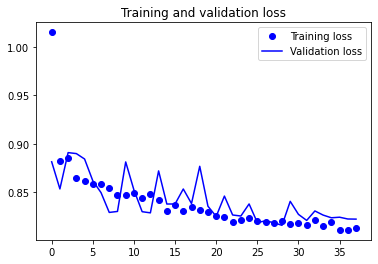

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_updated_dataset_exp1.h5'))

45/45 [==============================] - 37s 533ms/step - loss: 0.7611 - accuracy: 0.7142
Test accuracy: 0.714
Test loss: 0.761
Classification report: 
              precision    recall  f1-score   support

           0     0.6881    0.6265    0.6559       324
           1     0.7468    0.7420    0.7444       314
           2     0.6803    0.7875    0.7300       400
           3     0.7500    0.6900    0.7188       400

    accuracy                         0.7142      1438
   macro avg     0.7163    0.7115    0.7123      1438
weighted avg     0.7160    0.7142    0.7133      1438



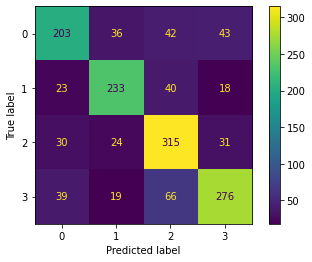

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 1 Fine Tune Last Block] Global AVG Pooling + 2 Dense 64**

In [ ]:
updated_dataset_model = 'CheXNet_updated_dataset_exp1'

In [ ]:
model = get_model_to_fine_tune(updated_dataset_model, num_of_layers=5)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_updated_dataset_ft_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=9, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 0.8194 - accuracy: 0.6805
Epoch 00001: val_loss improved from inf to 0.81679, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_updated_dataset_ft_exp1.h5
349/349 [==============================] - 96s 251ms/step - loss: 0.8194 - accuracy: 0.6805 - val_loss: 0.8168 - val_accuracy: 0.6896 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.8186 - accuracy: 0.6817
Epoch 00002: val_loss improved from 0.81679 to 0.81625, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_updated_dataset_ft_exp1.h5
349/349 [==============================] - 86s 246ms/step - loss: 0.8186 - accuracy: 0.6817 - val_loss: 0.8162 - val_accuracy: 0.6858 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.6812
Epoch 00003: val_loss improved from 0.81625 to 0.81542, saving model to /content/drive/MyDrive/CIDL_Group/tmp_

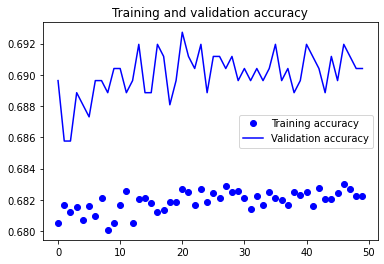

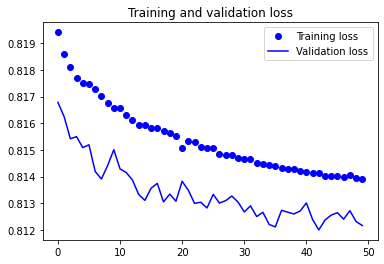

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_updated_dataset_ft_exp1.h5'))

45/45 [==============================] - 12s 216ms/step - loss: 0.7568 - accuracy: 0.7197
Test accuracy: 0.720
Test loss: 0.757
Classification report: 
              precision    recall  f1-score   support

           0     0.6983    0.6358    0.6656       324
           1     0.7476    0.7452    0.7464       314
           2     0.6957    0.7775    0.7344       400
           3     0.7415    0.7100    0.7254       400

    accuracy                         0.7197      1438
   macro avg     0.7208    0.7171    0.7179      1438
weighted avg     0.7204    0.7197    0.7190      1438



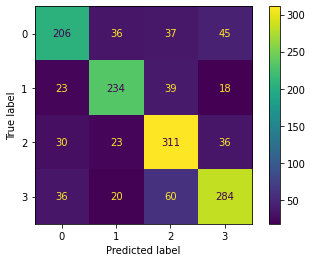

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 1 Fine Tune Last 12 Layers] Global AVG Pooling + 2 Dense 64**

In [ ]:
model = get_model_to_fine_tune(updated_dataset_model, num_of_layers=12)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
history = run_model(model, 'CheXNet_updated_dataset_ft2_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=9, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 0.8228 - accuracy: 0.6809
Epoch 1: val_loss improved from inf to 0.81755, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_updated_dataset_ft2_exp1.h5
349/349 [==============================] - 256s 298ms/step - loss: 0.8228 - accuracy: 0.6809 - val_loss: 0.8176 - val_accuracy: 0.6881 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.8214 - accuracy: 0.6828
Epoch 2: val_loss improved from 0.81755 to 0.81600, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_updated_dataset_ft2_exp1.h5
349/349 [==============================] - 89s 254ms/step - loss: 0.8214 - accuracy: 0.6828 - val_loss: 0.8160 - val_accuracy: 0.6889 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.8211 - accuracy: 0.6815
Epoch 3: val_loss improved from 0.81600 to 0.81514, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/Ch

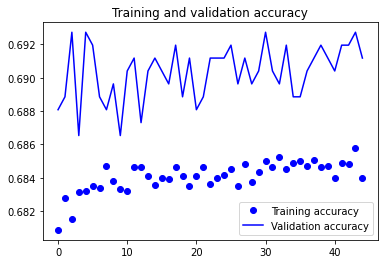

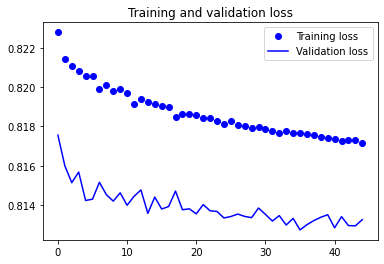

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_updated_dataset_ft2_exp1.h5'))

45/45 [==============================] - 25s 422ms/step - loss: 0.7567 - accuracy: 0.7197
Test accuracy: 0.720
Test loss: 0.757
Classification report: 
              precision    recall  f1-score   support

           0     0.7045    0.6327    0.6667       324
           1     0.7453    0.7548    0.7500       314
           2     0.6968    0.7700    0.7316       400
           3     0.7364    0.7125    0.7243       400

    accuracy                         0.7197      1438
   macro avg     0.7208    0.7175    0.7181      1438
weighted avg     0.7201    0.7197    0.7189      1438



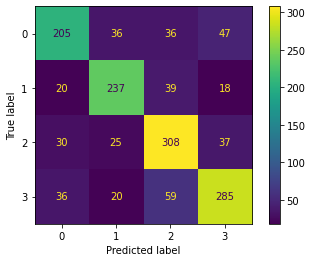

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

# **New Dataset**

In [10]:
!unzip /content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00029596_001.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00025252_014.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00010007_168.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00021565_008.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00018125_003.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00028509_011.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00010145_002.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00010805_035.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPRO

In [11]:
UPDATED_DATASET = '/content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED'
TRAIN_PATH = os.path.join(UPDATED_DATASET, 'train')
VAL_PATH = os.path.join(UPDATED_DATASET, 'val')
TEST_PATH = os.path.join(UPDATED_DATASET, 'test')

CLASSES = os.listdir(TRAIN_PATH)

100%|██████████| 4/4 [00:00<00:00, 91.56it/s]

Number of Effusion: 2279, proportion: 0.20452301893565467
Number of Infiltration: 3240, proportion: 0.2907655030063717
Number of No Finding: 3240, proportion: 0.2907655030063717
Number of Atelectasis: 2384, proportion: 0.2139459750516019


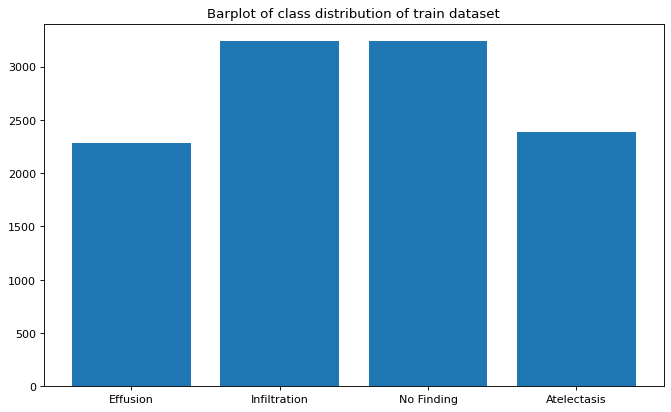

100%|██████████| 4/4 [00:00<00:00, 591.71it/s]


Number of Effusion: 283, proportion: 0.21904024767801858
Number of Infiltration: 360, proportion: 0.2786377708978328
Number of No Finding: 360, proportion: 0.2786377708978328
Number of Atelectasis: 289, proportion: 0.2236842105263158


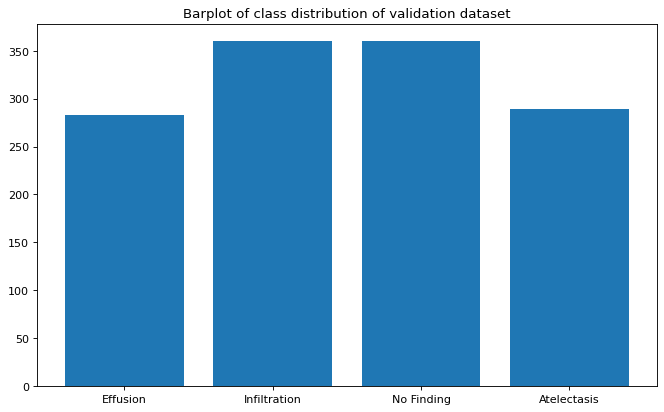

100%|██████████| 4/4 [00:00<00:00, 301.04it/s]


Number of Effusion: 314, proportion: 0.21835883171070933
Number of Infiltration: 400, proportion: 0.27816411682892905
Number of No Finding: 400, proportion: 0.27816411682892905
Number of Atelectasis: 324, proportion: 0.22531293463143254


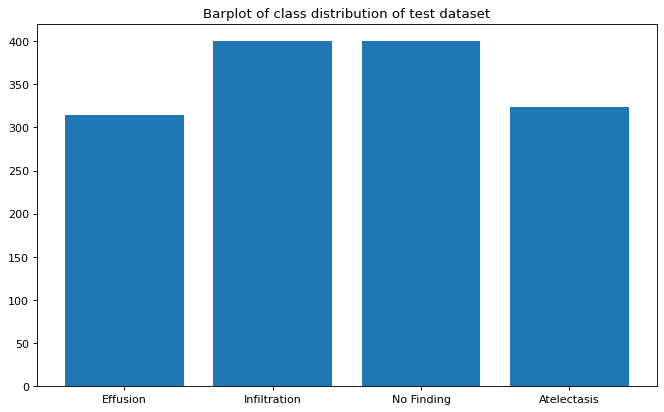

In [12]:
plot_class_distribution(TRAIN_PATH, 'train')
plot_class_distribution(VAL_PATH, 'validation')
plot_class_distribution(TEST_PATH, 'test')

In [13]:
train_set = load_training_set(IMAGE_SIZE, BATCH_SIZE)
val_set = load_validation_set(IMAGE_SIZE, BATCH_SIZE)
test_set = load_test_set(IMAGE_SIZE, BATCH_SIZE)

Found 11143 files belonging to 4 classes.
Found 1292 files belonging to 4 classes.
Found 1438 files belonging to 4 classes.


### **Experiment 1] Global AVG Pooling + 2 Dense 64**

In [14]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.densenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0   

In [15]:
history = run_model(model, 'CheXNet_preprocessed_dataset_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=9, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.2424 - accuracy: 0.4189
Epoch 1: val_loss improved from inf to 1.17631, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_preprocessed_dataset_exp1.h5
349/349 [==============================] - 240s 289ms/step - loss: 1.2424 - accuracy: 0.4189 - val_loss: 1.1763 - val_accuracy: 0.4760 - lr: 0.0010
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 1.0928 - accuracy: 0.5323
Epoch 2: val_loss improved from 1.17631 to 1.06019, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_preprocessed_dataset_exp1.h5
349/349 [==============================] - 90s 258ms/step - loss: 1.0928 - accuracy: 0.5323 - val_loss: 1.0602 - val_accuracy: 0.5774 - lr: 0.0010
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 1.0564 - accuracy: 0.5586
Epoch 3: val_loss improved from 1.06019 to 1.04332, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_

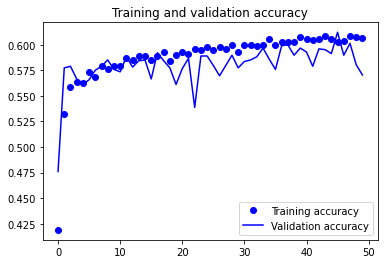

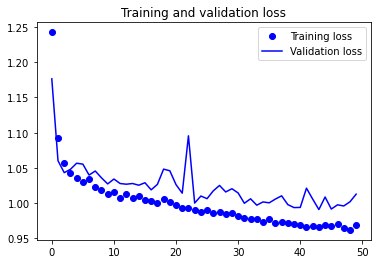

In [16]:
show_training_and_validation_performance(history)

In [17]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_preprocessed_dataset_exp1.h5'))

45/45 [==============================] - 22s 374ms/step - loss: 0.9724 - accuracy: 0.6113
Test accuracy: 0.611
Test loss: 0.972
Classification report: 
              precision    recall  f1-score   support

           0     0.5498    0.3920    0.4577       324
           1     0.6160    0.7357    0.6705       314
           2     0.5739    0.7475    0.6493       400
           3     0.7138    0.5550    0.6245       400

    accuracy                         0.6113      1438
   macro avg     0.6134    0.6075    0.6005      1438
weighted avg     0.6166    0.6113    0.6039      1438



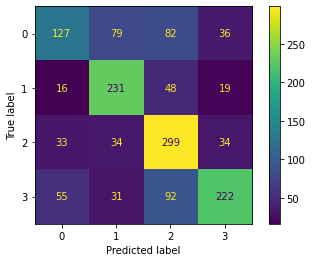

In [18]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [19]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 1 Fine Tune Last Block] Global AVG Pooling + 2 Dense 64**

In [20]:
updated_dataset_model = 'CheXNet_preprocessed_dataset_exp1'

In [21]:
model = get_model_to_fine_tune(updated_dataset_model, num_of_layers=5)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0   

In [22]:
history = run_model(model, 'CheXNet_preprocessed_dataset_ft_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=9, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.0289 - accuracy: 0.5845
Epoch 1: val_loss improved from inf to 1.00494, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_preprocessed_dataset_ft_exp1.h5
349/349 [==============================] - 100s 260ms/step - loss: 1.0289 - accuracy: 0.5845 - val_loss: 1.0049 - val_accuracy: 0.5929 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.9982 - accuracy: 0.5953
Epoch 2: val_loss improved from 1.00494 to 1.00309, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/CheXNet_preprocessed_dataset_ft_exp1.h5
349/349 [==============================] - 89s 255ms/step - loss: 0.9982 - accuracy: 0.5953 - val_loss: 1.0031 - val_accuracy: 0.5960 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.9935 - accuracy: 0.5936
Epoch 3: val_loss improved from 1.00309 to 1.00019, saving model to /content/drive/MyDrive/CIDL_Group/tmp_m

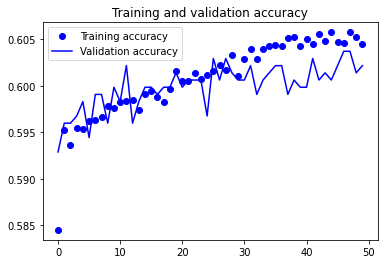

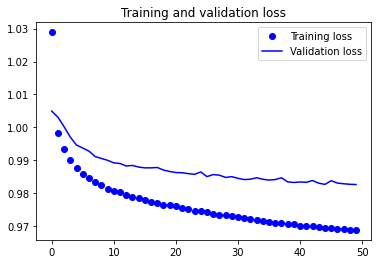

In [23]:
show_training_and_validation_performance(history)

In [24]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'CheXNet_preprocessed_dataset_ft_exp1.h5'))

45/45 [==============================] - 12s 225ms/step - loss: 0.9630 - accuracy: 0.6099
Test accuracy: 0.610
Test loss: 0.963
Classification report: 
              precision    recall  f1-score   support

           0     0.5336    0.4907    0.5113       324
           1     0.6741    0.6783    0.6762       314
           2     0.5708    0.6750    0.6186       400
           3     0.6695    0.5875    0.6258       400

    accuracy                         0.6099      1438
   macro avg     0.6120    0.6079    0.6080      1438
weighted avg     0.6124    0.6099    0.6090      1438



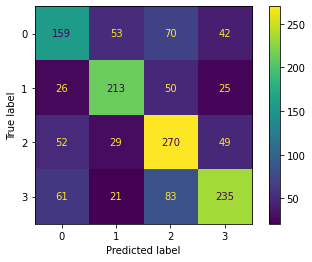

In [25]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [26]:
del model
del model_loaded
gc.collect()
K.clear_session()